In [2]:
using TimeSeries
using DataFrames
import Proj4
using Optim
using Distances
using Statistics
using Printf
;

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [4]:
using Revise
import TempModel
using GaussianProcesses

# Data Import and Preprocessing

In [5]:
include("iowa.jl")
data_dir = "../data"
iowa = prepare_iowa_data(data_dir);

# `sumprod` sum of products kernel

In [16]:
function make_kernel()
    kt1 = Periodic(log(1.0),log(3.0),log(24.0))
    kt2 = RQIso(log(0.5),0.0,0.0)  # half an hour
    kt3 = RQIso(log(2.0),0.0,0.0)  # two hours
    kt4 = RQIso(log(12.0),0.0,0.0) # twelve hours

    ksp1 = Mat32Iso(log(5e4), log(1.0))
    ksp2 = Mat32Iso(log(5e4), log(1.0))
    ksp3 = Mat32Iso(log(5e4), log(1.0))
    ksp4 = Mat32Iso(log(5e4), log(1.0))
    
    kn1 = Noise(0.0)
    kn2 = Noise(0.0)
    kn3 = Noise(0.0)
    kn4 = Noise(0.0)
    
    k_means = Noise(log(40.0))
    k_slow = SEIso(log(24.0*5.0), log(40.0))
    
    kprod(ktime, kspace, knoise) = Masked(fix(ktime, :lσ), [1]) * 
                  (Masked(kspace, [2,3]) + Masked(knoise, [2,3]))

    k_spatiotemporal = kprod(fix(kt1, :lp), ksp1, kn1) +
                       kprod(kt2, ksp2, kn2) +
                       kprod(kt3, ksp3, kn3) +
                       kprod(kt4, ksp4, kn4) +
                       fix(Masked(k_means, [2,3])) +
                       fix(Masked(k_slow, [1]))
    return Dict(
        :time1=>kt1, :time2=>kt2, :time3=>kt3, :time4=>kt4,
        :space1=>ksp1, :space2=>ksp2, :space3=>ksp3, :space4=>ksp4,
        :noise1=>kn1, :noise2=>kn2, :noise3=>kn3, :noise4=>kn4,
        :mean=>k_means,
        :slow=>k_slow,
        :spatiotemporal => k_spatiotemporal
        )
end

function showkernel(kdict, logNoise)
    print("k₁: Periodic \n=================\n")
    Printf.@printf("l: %5.3f\n", √kdict[:time1].ℓ2)
    Printf.@printf("p: %5.0f hours\n", kdict[:time1].p)
    print("> spatial decay:\n")
    Printf.@printf("l: %5.3f km\n", kdict[:space1].ℓ / 1000)
    Printf.@printf("σ: %5.3f °C\n", √kdict[:space1].σ2)
    print("> local component:\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:noise1].σ2)
    print("\nk₂: RQIso \n=================\n")
    Printf.@printf("l: %5.3f hours\n", √kdict[:time2].ℓ2)
    Printf.@printf("α: %5.3f\n", kdict[:time2].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp2.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space2].ℓ / 1000)
    Printf.@printf("σ: %5.3f °C\n", √kdict[:space2].σ2)
    print("> local component:\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:noise2].σ2)
    print("\nk₃: RQIso \n=================\n")
    Printf.@printf("l: %5.3f hours\n", √kdict[:time3].ℓ2)
    Printf.@printf("α: %5.3f\n", kdict[:time3].α)
    print("> spatial decay:\n")
    Printf.@printf("l: %5.3f km\n", kdict[:space3].ℓ / 1000)
    Printf.@printf("σ: %5.3f °C\n", √kdict[:space3].σ2)
    print("> local component:\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:noise3].σ2)
    print("\nk₄: RQIso \n=================\n")
    Printf.@printf("l: %5.3f days\n", √kdict[:time4].ℓ2 / 24)
    Printf.@printf("α: %5.3f\n",  kdict[:time4].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp4.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space4].ℓ / 1000)
    Printf.@printf("σ: %5.3f °C\n", √kdict[:space4].σ2)
    print("> local component:\n")
    Printf.@printf("σ: %5.3f °C\n", √kdict[:noise4].σ2)
    print("\n=================\n")
    Printf.@printf("σy: %5.3f\n", exp(logNoise))
end
;

# optimize

In [17]:
kdict = make_kernel()
showkernel(kdict, 0.0)

k₁: Periodic 
l: 1.000
p:    24 hours
> spatial decay:
l: 50.000 km
σ: 1.000 °C
> local component:
σ: 1.000 °C

k₂: RQIso 
l: 0.500 hours
α: 1.000
> spatial decay:
l: 50.000 km
σ: 1.000 °C
> local component:
σ: 1.000 °C

k₃: RQIso 
l: 2.000 hours
α: 1.000
> spatial decay:
l: 50.000 km
σ: 1.000 °C
> local component:
σ: 1.000 °C

k₄: RQIso 
l: 0.500 days
α: 1.000
> spatial decay:
l: 50.000 km
σ: 1.000 °C
> local component:
σ: 1.000 °C

σy: 1.000


In [18]:
iowa[:isdSubset]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Float64,Float64
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [19]:
reals, folds_reals = TempModel.make_chunks_and_folds(kdict[:spatiotemporal], -1.0, 
        iowa[:isdSubset], iowa[:hourly_data]; window=Day(5))
;

creating GP chunks


In [20]:
od = TempModel.get_optim_target(reals; noise=true, domean=false, kern=true)

OnceDifferentiable{Float64,Array{Float64,1},Array{Float64,1}}(getfield(TempModel, Symbol("#mll#7")){Bool,Bool,Bool,TempModel.GPRealisations}(true, false, true, TempModel.GPRealisations(GPE[GP Exact object:
  Dim = 3
  Number of observations = 720
  Mean function:
    Type: MeanConst, Params: [-8.30125]
  Kernel:
    Type: SumKernel{SumKernel{SumKernel{SumKernel{SumKernel{ProdKernel{Masked{FixedKernel{Periodic{Float64},1},1},SumKernel{Masked{Mat32Iso{Float64},2},Masked{Noise{Float64},2}}},ProdKernel{Masked{FixedKernel{RQIso{Float64},2},1},SumKernel{Masked{Mat32Iso{Float64},2},Masked{Noise{Float64},2}}}},ProdKernel{Masked{FixedKernel{RQIso{Float64},2},1},SumKernel{Masked{Mat32Iso{Float64},2},Masked{Noise{Float64},2}}}},ProdKernel{Masked{FixedKernel{RQIso{Float64},2},1},SumKernel{Masked{Mat32Iso{Float64},2},Masked{Noise{Float64},2}}}},FixedKernel{Masked{Noise{Float64},2},0}},FixedKernel{Masked{SEIso{Float64},1},0}}
      Type: SumKernel{SumKernel{SumKernel{SumKernel{ProdKernel{Masked{Fixe

In [21]:
@time od.f(opt_out[:hyp])

UndefVarError: UndefVarError: opt_out not defined

In [22]:
@time od.df(similar(opt_out[:hyp]), opt_out[:hyp])

UndefVarError: UndefVarError: opt_out not defined

In [23]:
@time GaussianProcesses.dlogpdθ_CVfold(reals, folds_reals; noise=true, domean=false, kern=true)

 66.058981 seconds (359.84 M allocations: 19.528 GiB, 11.97% gc time)


20-element Array{Float64,1}:
  -7716.3924464712045 
   1950.9959404405486 
    230.47386586476466
   -434.73274649400366
   -589.0922452108084 
  10307.017875776704  
  -2097.422490401853  
    680.6886632123277 
 -10624.844306678655  
 -11105.547337941196  
   3206.812967942074  
    -26.50995697253289
    792.4862100014541 
   -719.1168271775209 
  -1259.2986347054793 
   -400.5545556639685 
     68.15193503483101
    386.2957610784949 
    361.11169418961873
    102.03782478906098

In [24]:
@time GaussianProcesses.dlogpdθ_CVfold(reals_old, folds_reals; noise=true, domean=false, kern=true)

UndefVarError: UndefVarError: reals_old not defined

In [25]:
kspt_old, logNoise = TempModel.fitted_sptemp_matern(;kmean=true)
reals_old, folds_reals = TempModel.make_chunks_and_folds(kspt_old, -1.0, 
        iowa[:isdSubset], iowa[:hourly_data]; window=Day(5))
;

creating GP chunks


In [26]:
od_old = TempModel.get_optim_target(reals_old; noise=true, domean=false, kern=true);

In [27]:
hyp = [logNoise; GaussianProcesses.get_params(kspt_old)]
@time od_old.f(hyp)

  4.179670 seconds (689.30 k allocations: 37.452 MiB)


47115.00879977801

In [28]:
@time od_old.df(similar(hyp), hyp)

 17.889167 seconds (2.35 M allocations: 111.849 MiB)


47115.00879977801

In [29]:
kdict = make_kernel()
@time opt_out = TempModel.optim_kernel(kdict[:spatiotemporal], 0.0, iowa[:isdSubset], iowa[:hourly_data], :Optim;
             x_tol=1e-4, f_tol=1e-5, window=Day(5));

creating GP chunks
begin optimization
3237.194768 seconds (54.13 G allocations: 1.971 TiB, 16.30% gc time)


In [30]:
opt_out[:mll]

-47591.93833555019

In [31]:
print(opt_out[:hyp])

[-1.67069, -0.00420038, 15.2506, 0.114064, -1.97427, 0.0219397, -3.13268, 8.95146, -1.95809, 0.352686, 1.71123, -1.20061, 12.5051, 1.13736, -1.54326, 2.58608, -0.272638, 13.3629, -1.12144, -2.84086]

In [32]:
opt_out[:opt_out]

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-1.6706882472920432,-0.004200383751521355, ...]
 * Minimum: 4.759194e+04
 * Iterations: 61
 * Convergence: true
   * |x - x'| ≤ 1.0e-04: false 
     |x - x'| = 2.17e-02 
   * |f(x) - f(x')| ≤ 1.0e-05 |f(x)|: true
     |f(x) - f(x')| = 9.93e-06 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 9.12e+01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 142
 * Gradient Calls: 82

# Printing and plotting fitted variogram

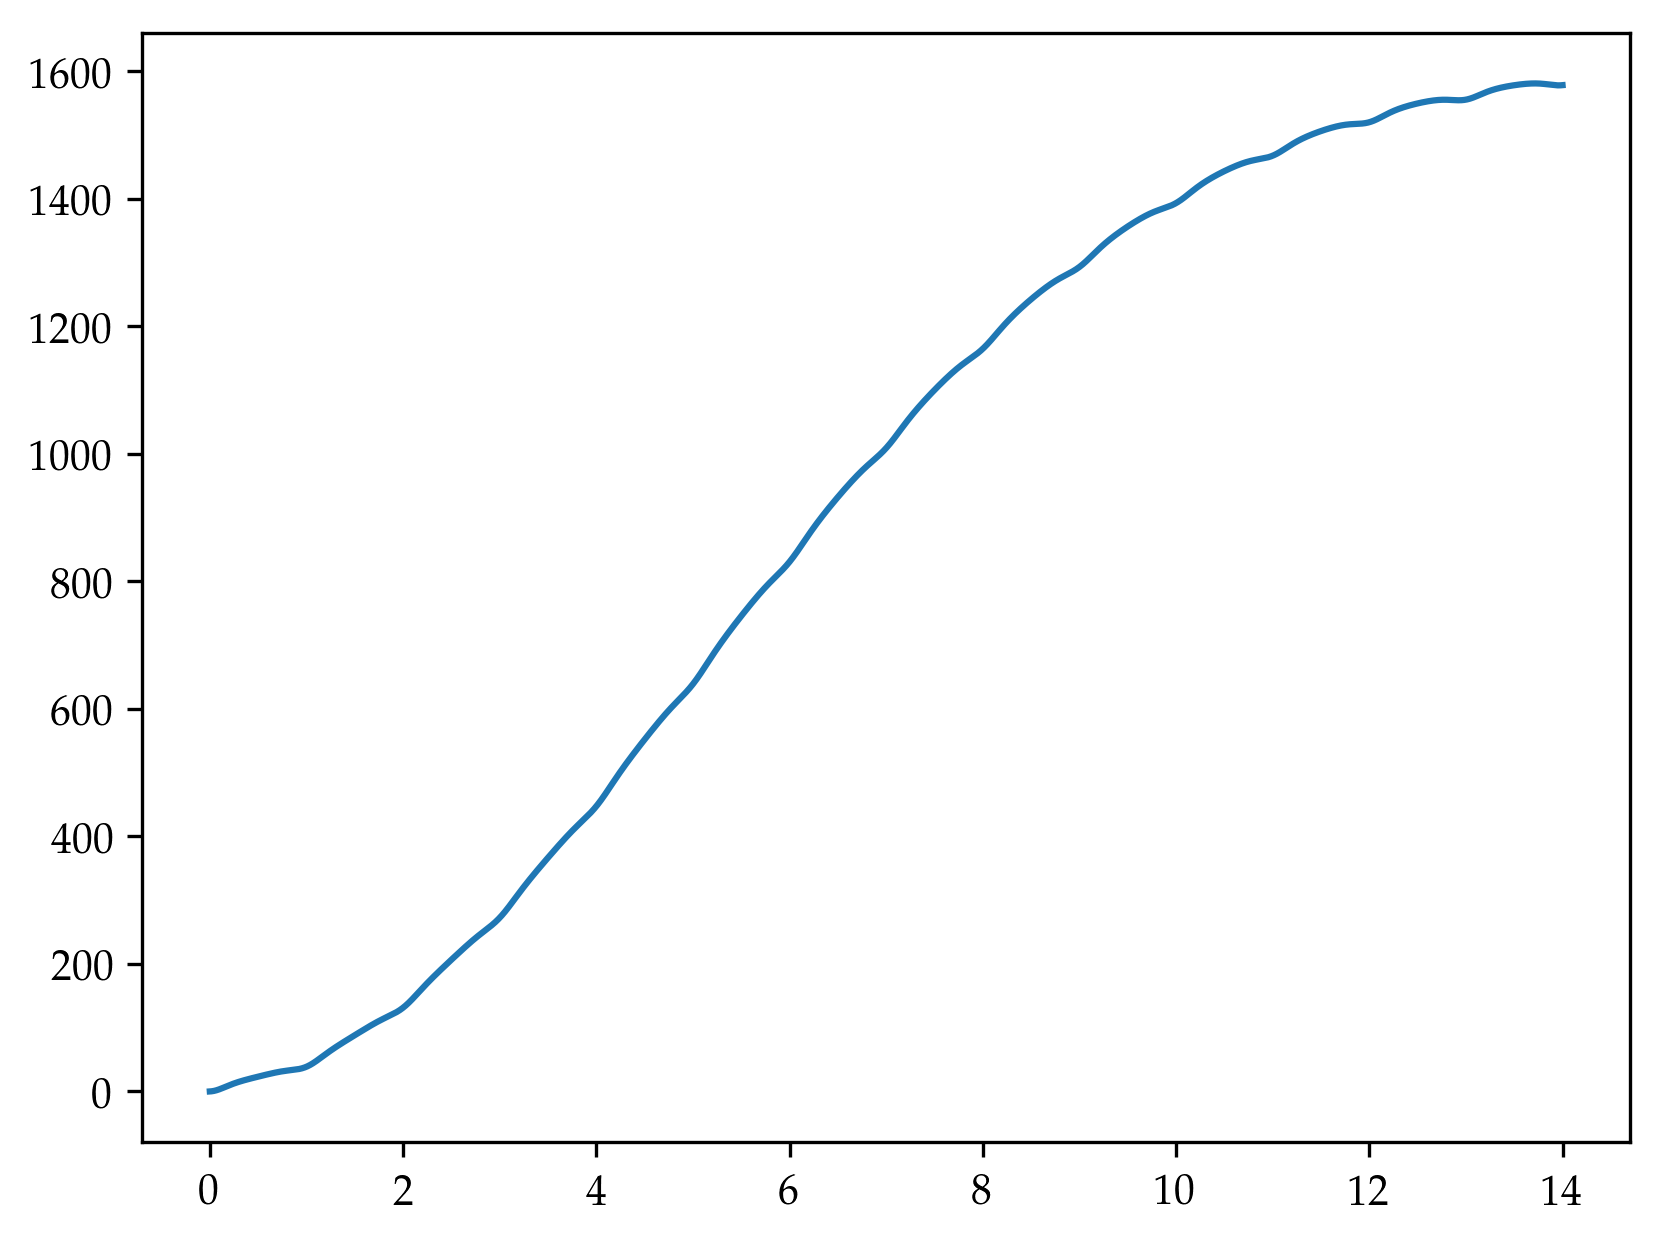

k₁: Periodic 
l: 0.996
p:    24 hours
> spatial decay:
l: 4199.941 km
σ: 1.121 °C
> local component:
σ: 0.139 °C

k₂: RQIso 
l: 1.022 hours
α: 0.044
> spatial decay:
l: 7.719 km
σ: 0.141 °C
> local component:
σ: 1.423 °C

k₃: RQIso 
l: 5.536 hours
α: 0.301
> spatial decay:
l: 269.707 km
σ: 3.119 °C
> local component:
σ: 0.214 °C

k₄: RQIso 
l: 0.553 days
α: 0.761
> spatial decay:
l: 635.955 km
σ: 0.326 °C
> local component:
σ: 0.058 °C

σy: 0.188


In [34]:
kdict = make_kernel()
hyp = opt_out[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])
showkernel(kdict, hyp[1])

σ2_y = exp(2*opt_out[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="fitted variogram")
;

# Using cross-validation metric

In [66]:
# start with the fitted marginal likelihood parameters
kdict = make_kernel(;kmean=true,kslow=false)
hyp = opt_out[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])

@time opt_out_CV = TempModel.optim_kernel_CV(kdict[:spatiotemporal], hyp[1], 
                                           iowa[:isdSubset], iowa[:hourly_data],
                                           window=Day(5), # shorter window is faster
                                           f_tol=1e-5, x_tol=1e-4,
                                           show_trace=true,
                                           show_every=5,
                                           time_limit=5000.0,
                                           :Optim);
opt_out_CV

creating GP chunks
begin optimization
3095.361351 seconds (27.18 G allocations: 1.339 TiB, 15.06% gc time)


Dict{Symbol,Any} with 5 entries:
  :converged => true
  :hyp       => [-1.72229, -0.558402, 15.1686, -0.761139, -2.74982, -1.31263, -…
  :minimum   => -44421.1
  :logNoise  => -1.72229
  :opt_out   => Results of Optimization Algorithm…

In [68]:
kdict = make_kernel(;kmean=false,kslow=false)
hyp = opt_out_CV[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])
showkernel(kdict, hyp[1])

k₁: Periodic 
l: 0.572
p:    24 hours
> spatial decay:
l: 3869.495 km
σ: 0.467 °C
> local component:
σ: 0.064 °C

k₂: RQIso 
l: 0.269 hours
α: 0.501
> spatial decay:
l: 7.666 km
σ: 0.065 °C
> local component:
σ: 0.436 °C

k₃: RQIso 
l: 1.585 hours
α: 3.562
> spatial decay:
l: 82.718 km
σ: 0.555 °C
> local component:
σ: 0.491 °C

k₄: RQIso 
l: 0.216 days
α: 3.187
> spatial decay:
l: 405.693 km
σ: 3.042 °C
> local component:
σ: 0.093 °C

σy: 0.179


opt_out_CV with kslow=true

```
Dict{Symbol,Any} with 5 entries:
  :converged => true
  :hyp       => [-1.72551, -0.207505, 15.4312, 0.997768, -2.65398, -1.23251, -1…
  :minimum   => -44429.1
  :logNoise  => -1.72551
  :opt_out   => Results of Optimization Algorithm…
```
```
Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-2.0,0.16043931128859723, ...]
 * Minimizer: [-1.7255092997819441,-0.2075048245239641, ...]
 * Minimum: 4.442906e+04
 * Iterations: 36
 * Convergence: true
   * |x - x'| ≤ 1.0e-04: false 
     |x - x'| = 7.19e-03 
   * |f(x) - f(x')| ≤ 1.0e-05 |f(x)|: true
     |f(x) - f(x')| = 7.09e-06 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.59e+01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 76
 * Gradient Calls: 41
```
```
k₁: Periodic 
=================
l: 0.813
p:    24 hours
> spatial decay:
l: 5031.589 km
σ: 2.712 °C
> local component:
σ: 0.070 °C

k₂: RQIso 
=================
l: 0.292 hours
α: 0.343
> spatial decay:
l: 15.781 km
σ: 0.144 °C
> local component:
σ: 0.463 °C

k₃: RQIso 
=================
l: 1.499 hours
α: 4.784
> spatial decay:
l: 85.482 km
σ: 0.476 °C
> local component:
σ: 0.474 °C

k₄: RQIso 
=================
l: 0.201 days
α: 2.352
> spatial decay:
l: 306.965 km
σ: 2.413 °C
> local component:
σ: 0.052 °C

=================
σy: 0.178
```

In [57]:
opt_out_CV

Dict{Symbol,Any} with 5 entries:
  :converged => true
  :hyp       => [-1.72551, -0.207505, 15.4312, 0.997768, -2.65398, -1.23251, -1…
  :minimum   => -44429.1
  :logNoise  => -1.72551
  :opt_out   => Results of Optimization Algorithm…

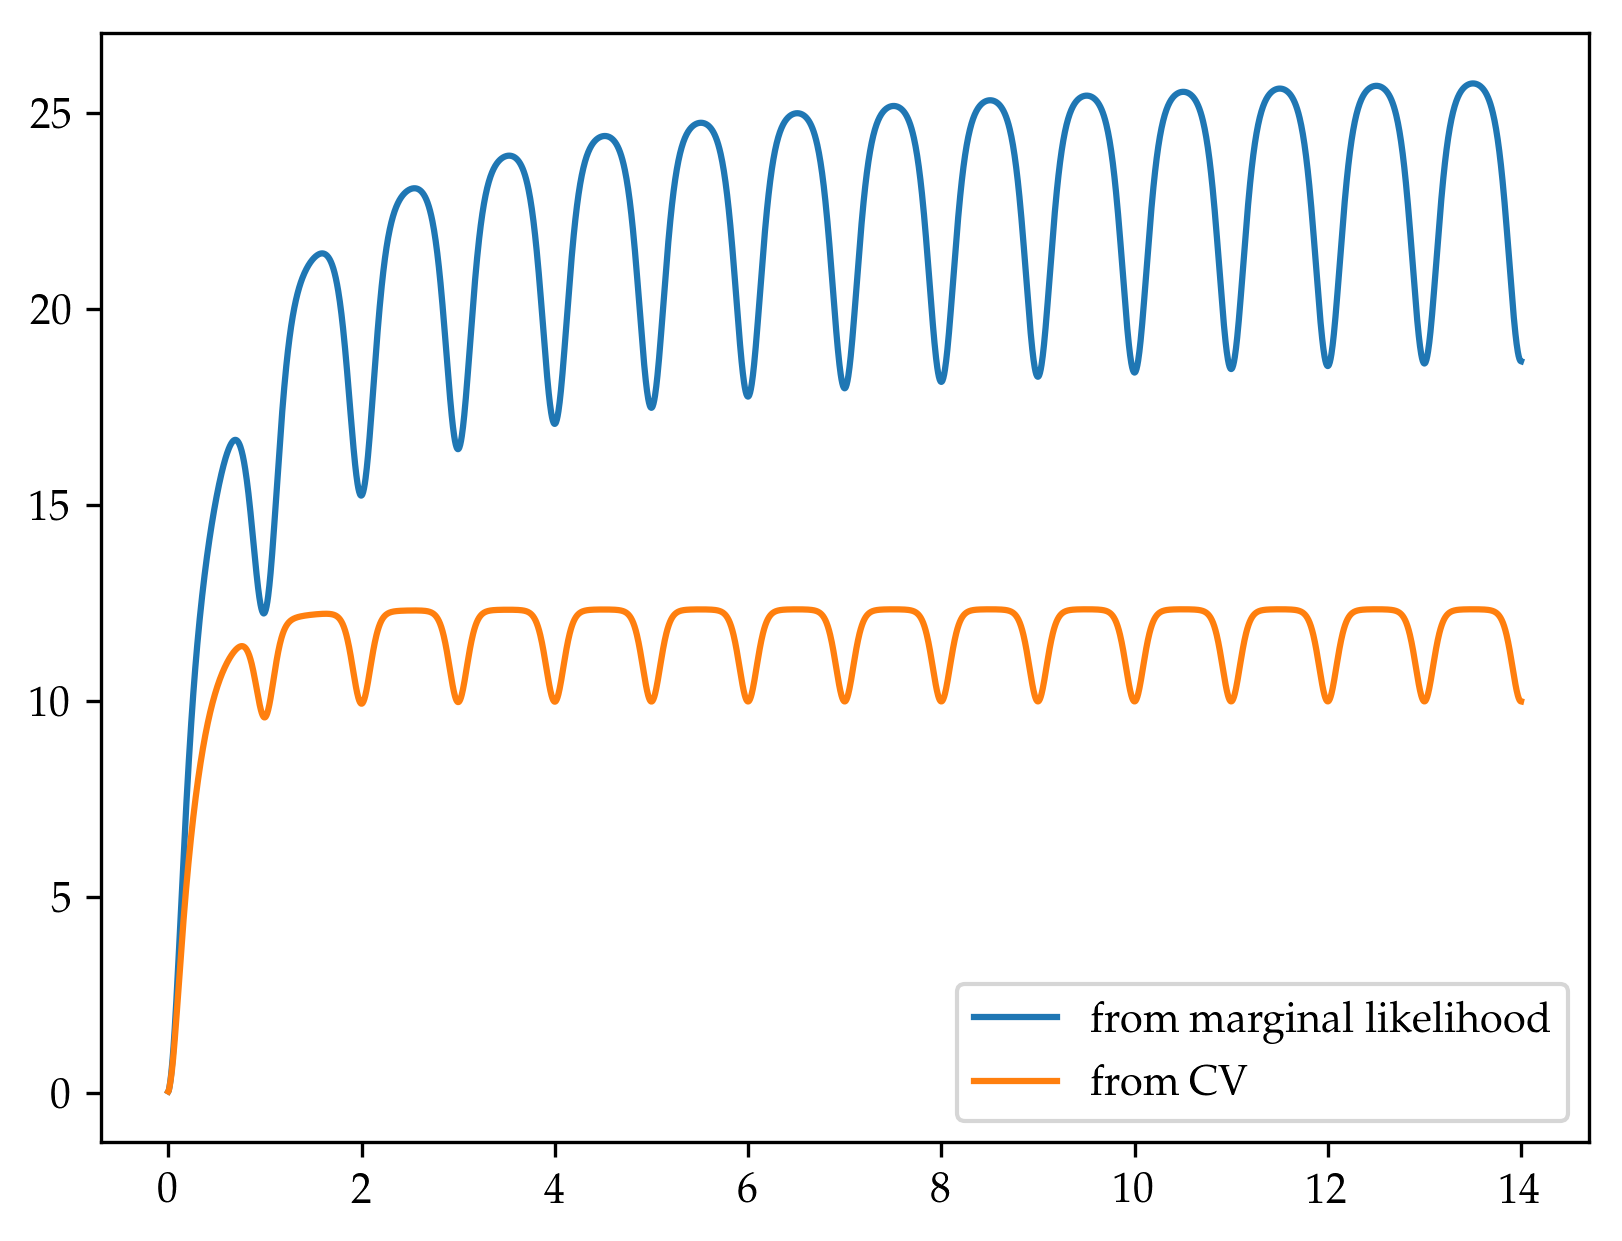

PyObject <matplotlib.legend.Legend object at 0x123f85550>

In [24]:
kdict = make_kernel()
hyp = opt_out[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])

σ2_y = exp(2*opt_out[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="from marginal likelihood")
;
kdict = make_kernel()
hyp = opt_out_CV[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])

σ2_y = exp(2*opt_out_CV[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="from CV")
;
plt.legend(loc="best")

That's actually a very different variogram!
It seems the model is no longer bothering to fit well at high timescales.
It makes sense that it would make very little difference to the quality of predictions,
where simultaneous observations are always available.
Another interesting phenomenon is that the variance parameter of each component has gone down by quite a lot.
This is significant as we were seeing overly conservative (inflated) predictive variances,
which were hurting the imputations.
There's good reason to believe this will solve that problem.

# Fitted kernel KBDL

In [7]:
kdict = make_kernel()
hyp = [
        -2.037981191817176,
        0.047778992619533146,
        16.427853121432094,
        1.170062986916456,
        -1.260221152061321,
        -1.7165097894082868,
        -4.887026596780306,
        10.031024949486289,
        -0.4193441871536279,
        0.2234423502733472,
        0.7209737338242688,
        -2.4691033436177,
        13.723900546864764,
        -0.9198855379445695,
        0.479277827990536,
        1.7635437569965557,
        -0.5659728451543391,
        12.7060285046103,
        0.9765786702195258,
        -1.2729899422018138
    ]
set_params!(kdict[:spatiotemporal], hyp[2:end])
showkernel(kdict, hyp[1])

k₁: Periodic 
l: 1.049
p:    24 hours
> spatial decay:
l: 13630.945 km
σ: 3.222 °C
> local component:
σ: 0.284 °C

k₂: RQIso 
l: 0.180 hours
α: 0.008
> spatial decay:
l: 22.721 km
σ: 0.657 °C
> local component:
σ: 1.250 °C

k₃: RQIso 
l: 2.056 hours
α: 0.085
> spatial decay:
l: 912.461 km
σ: 0.399 °C
> local component:
σ: 1.615 °C

k₄: RQIso 
l: 0.243 days
α: 0.568
> spatial decay:
l: 329.730 km
σ: 2.655 °C
> local component:
σ: 0.280 °C

σy: 0.130


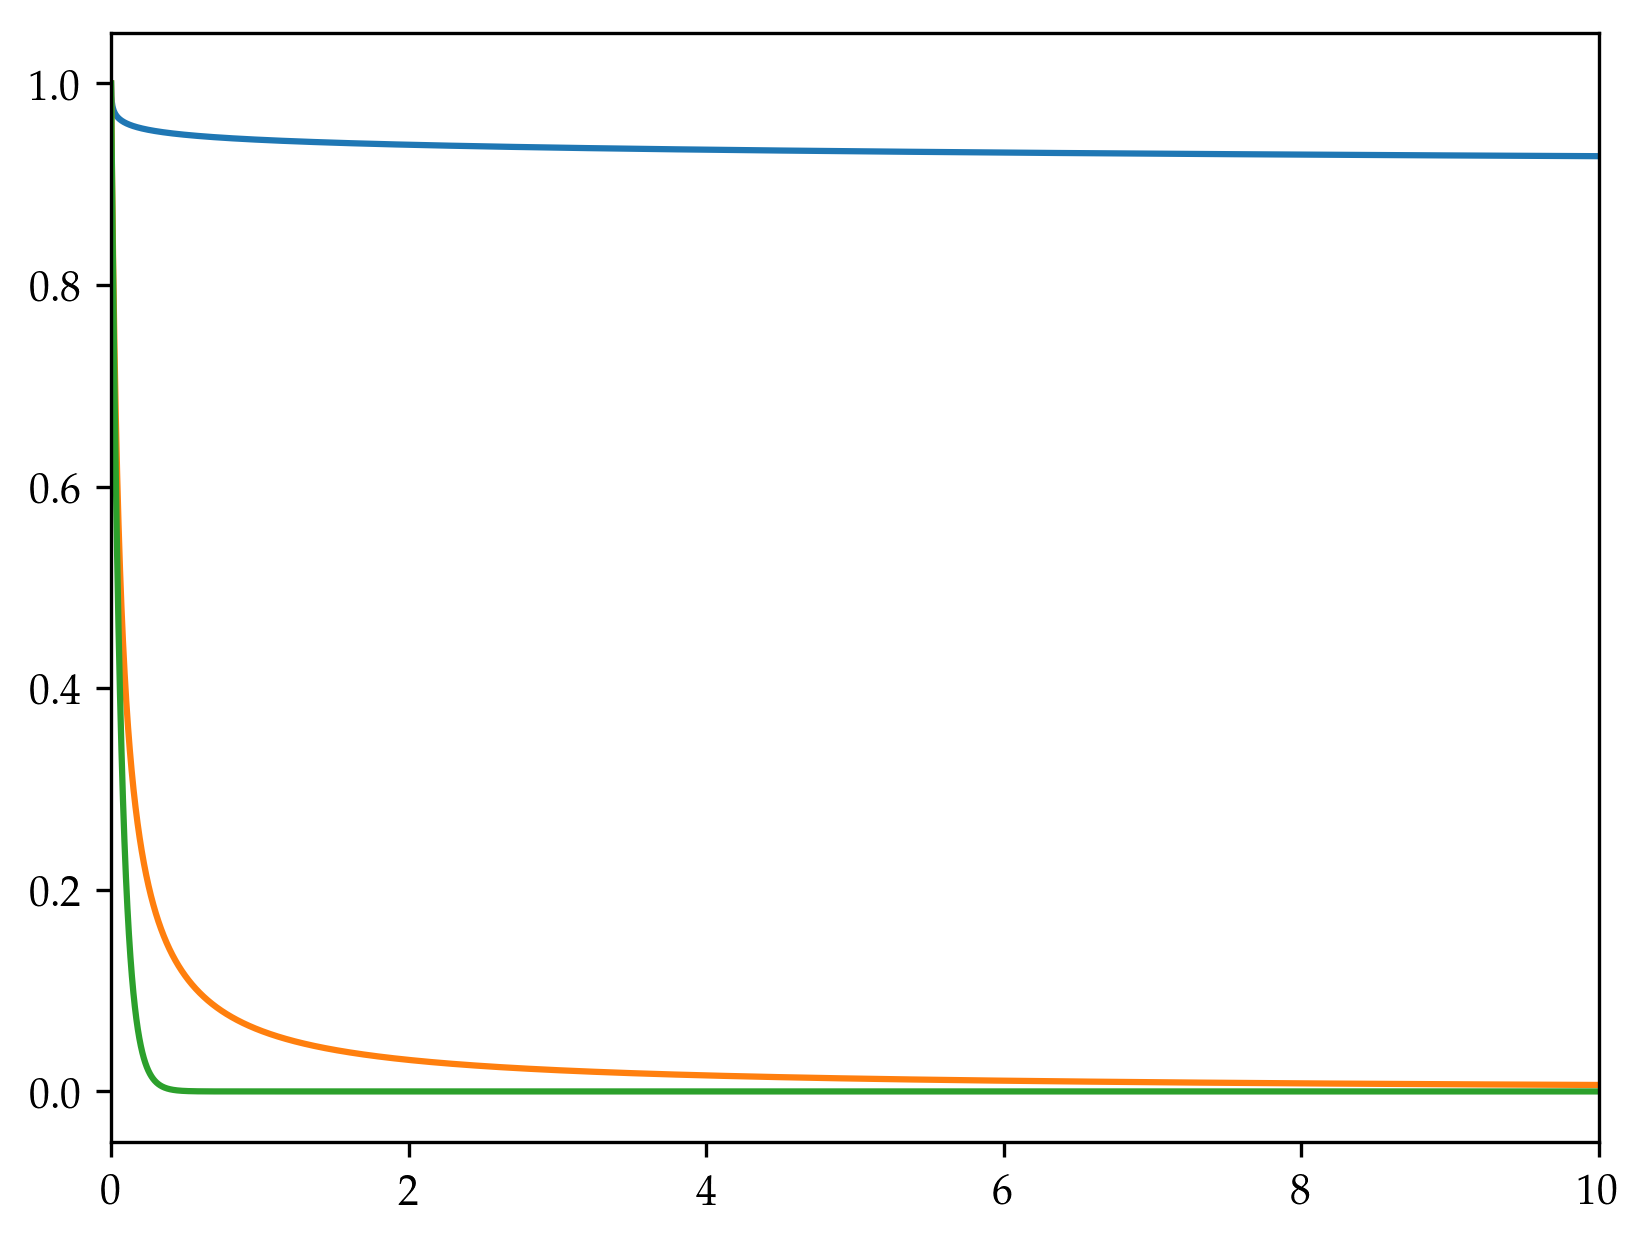

In [8]:
using GaussianProcesses: get_params
rr = range(0, stop=10.0, length=10000)
rq = kdict[:time2]
hyp = get_params(rq)
rq1 = RQIso(hyp[1], hyp[2], 0.0)
se = SEIso(hyp[1], hyp[2])
plt.plot(rr, cov.(Ref(rq), rr))
plt.plot(rr, cov.(Ref(rq1), rr))
plt.plot(rr, cov.(Ref(se), rr))
plt.xlim(0,10)
;

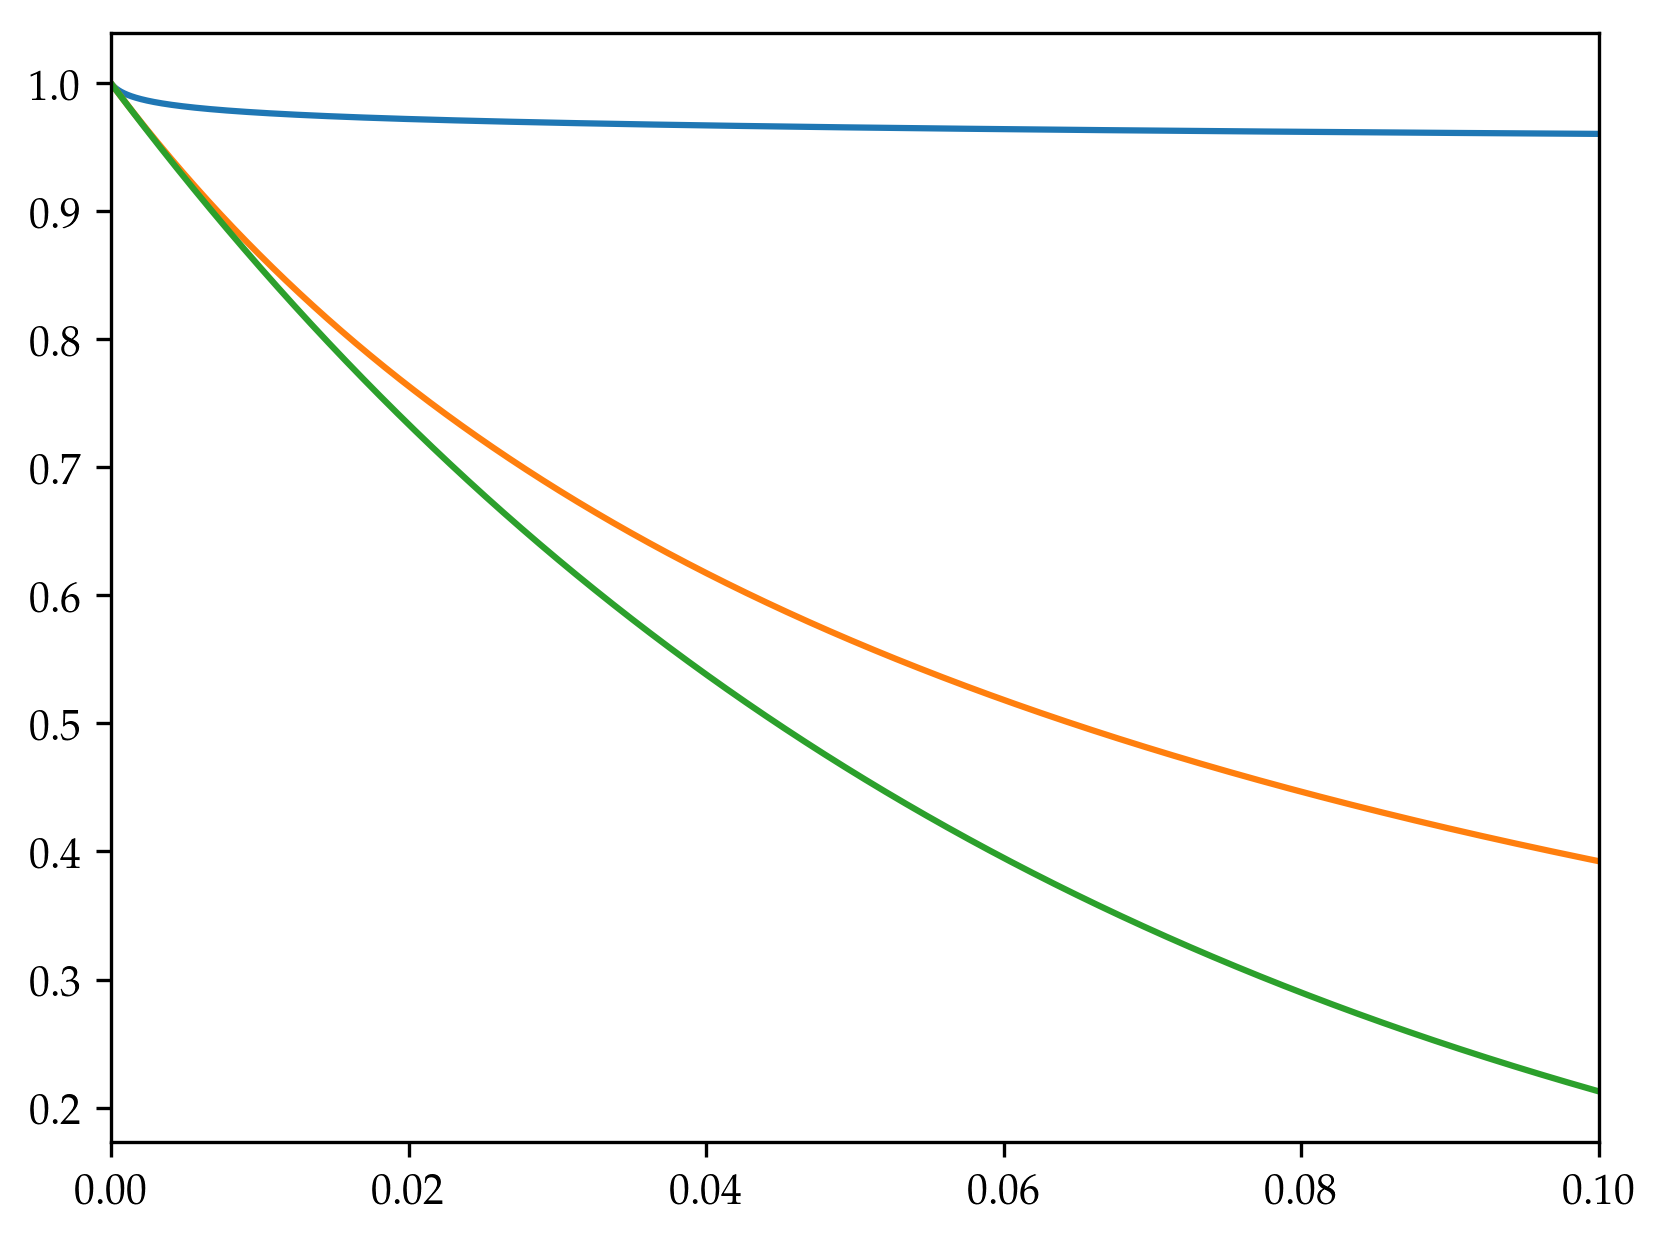

In [9]:
using GaussianProcesses: get_params
rr = range(0, stop=0.1, length=10000)
rq = kdict[:time2]
hyp = get_params(rq)
rq1 = RQIso(hyp[1], hyp[2], 0.0)
se = SEIso(hyp[1], hyp[2])
plt.plot(rr, cov.(Ref(rq), rr))
plt.plot(rr, cov.(Ref(rq1), rr))
plt.plot(rr, cov.(Ref(se), rr))
plt.xlim(0,0.1)
;

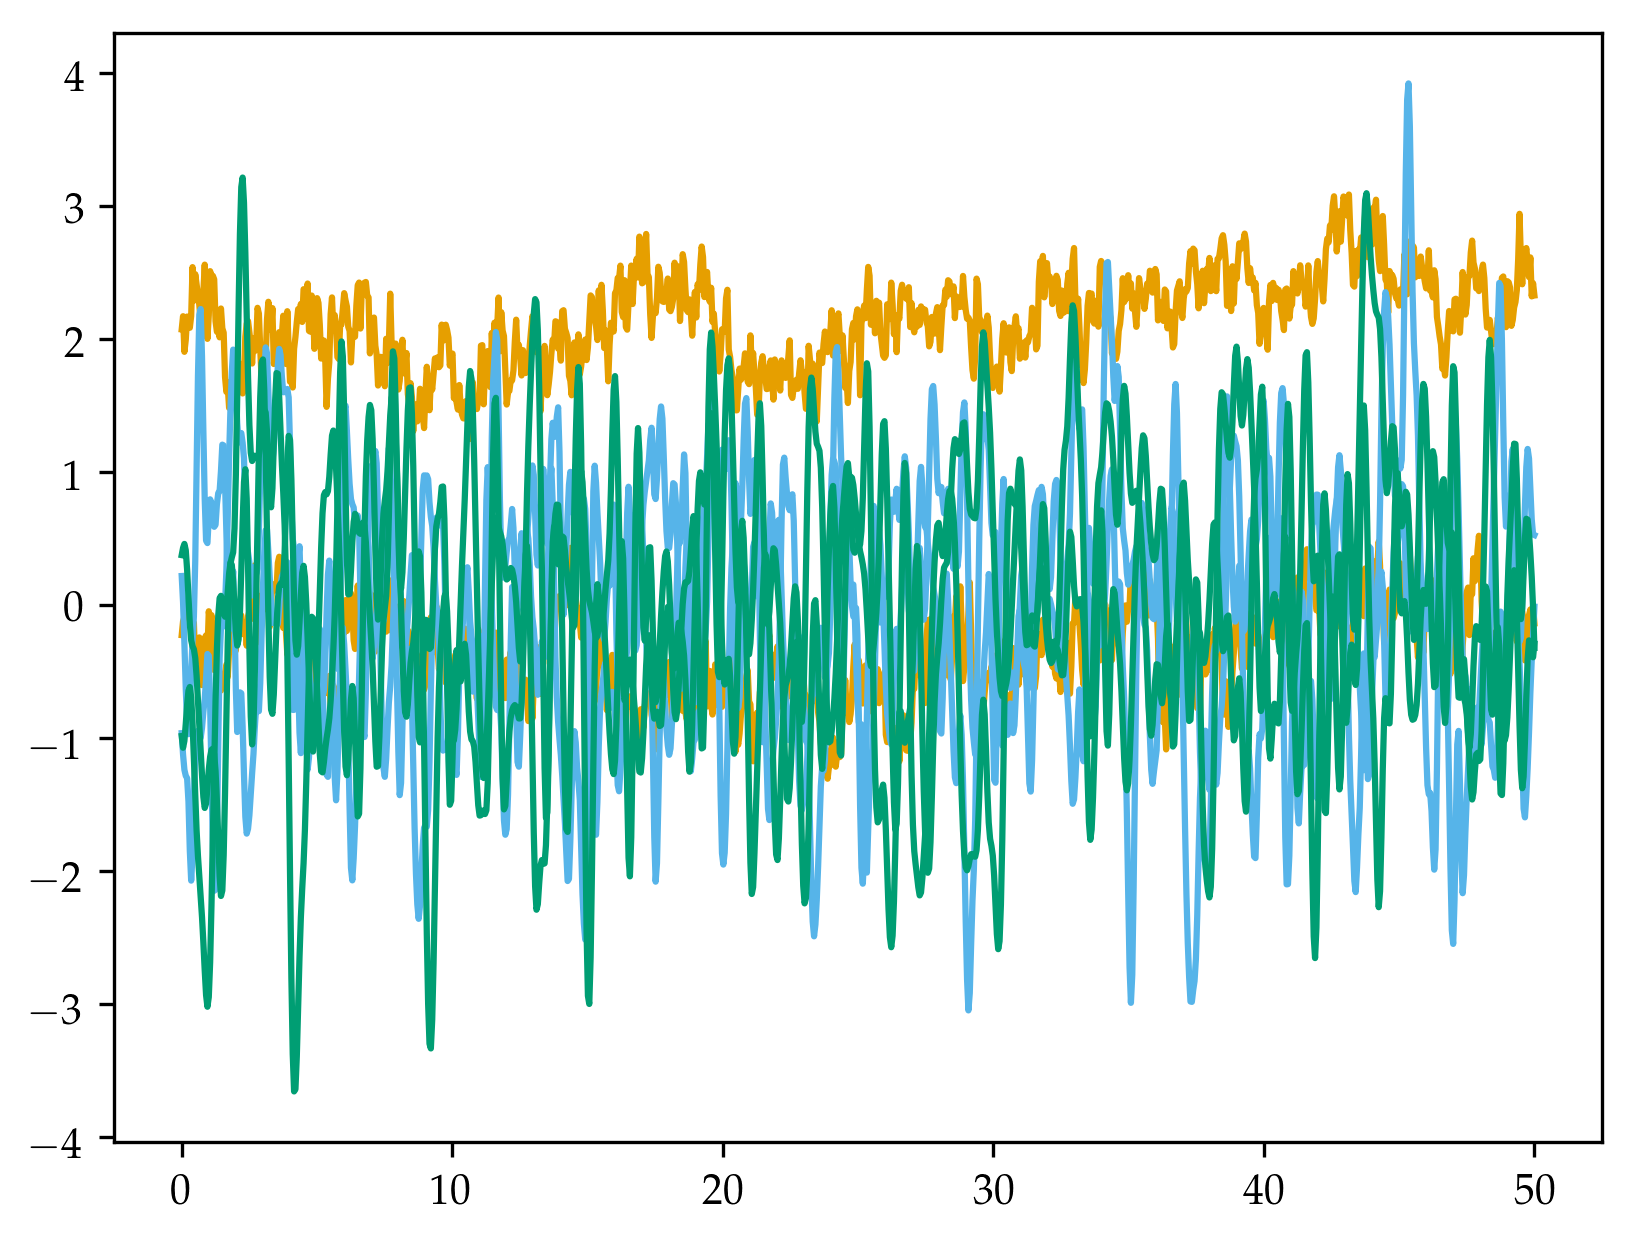

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x119c3d4a8>

In [10]:
rr = range(0, stop=50.0, length=1000)
X = Matrix(rr')
gp_rq = GPE(; mean=MeanZero(), kernel=rq, logNoise=-20.0)
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
gp_rq1 = GPE(; mean=MeanZero(), kernel=rq1, logNoise=-20.0)
plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])
plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])
gp_se = GPE(; mean=MeanZero(), kernel=se, logNoise=-20.0)
plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])
plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])

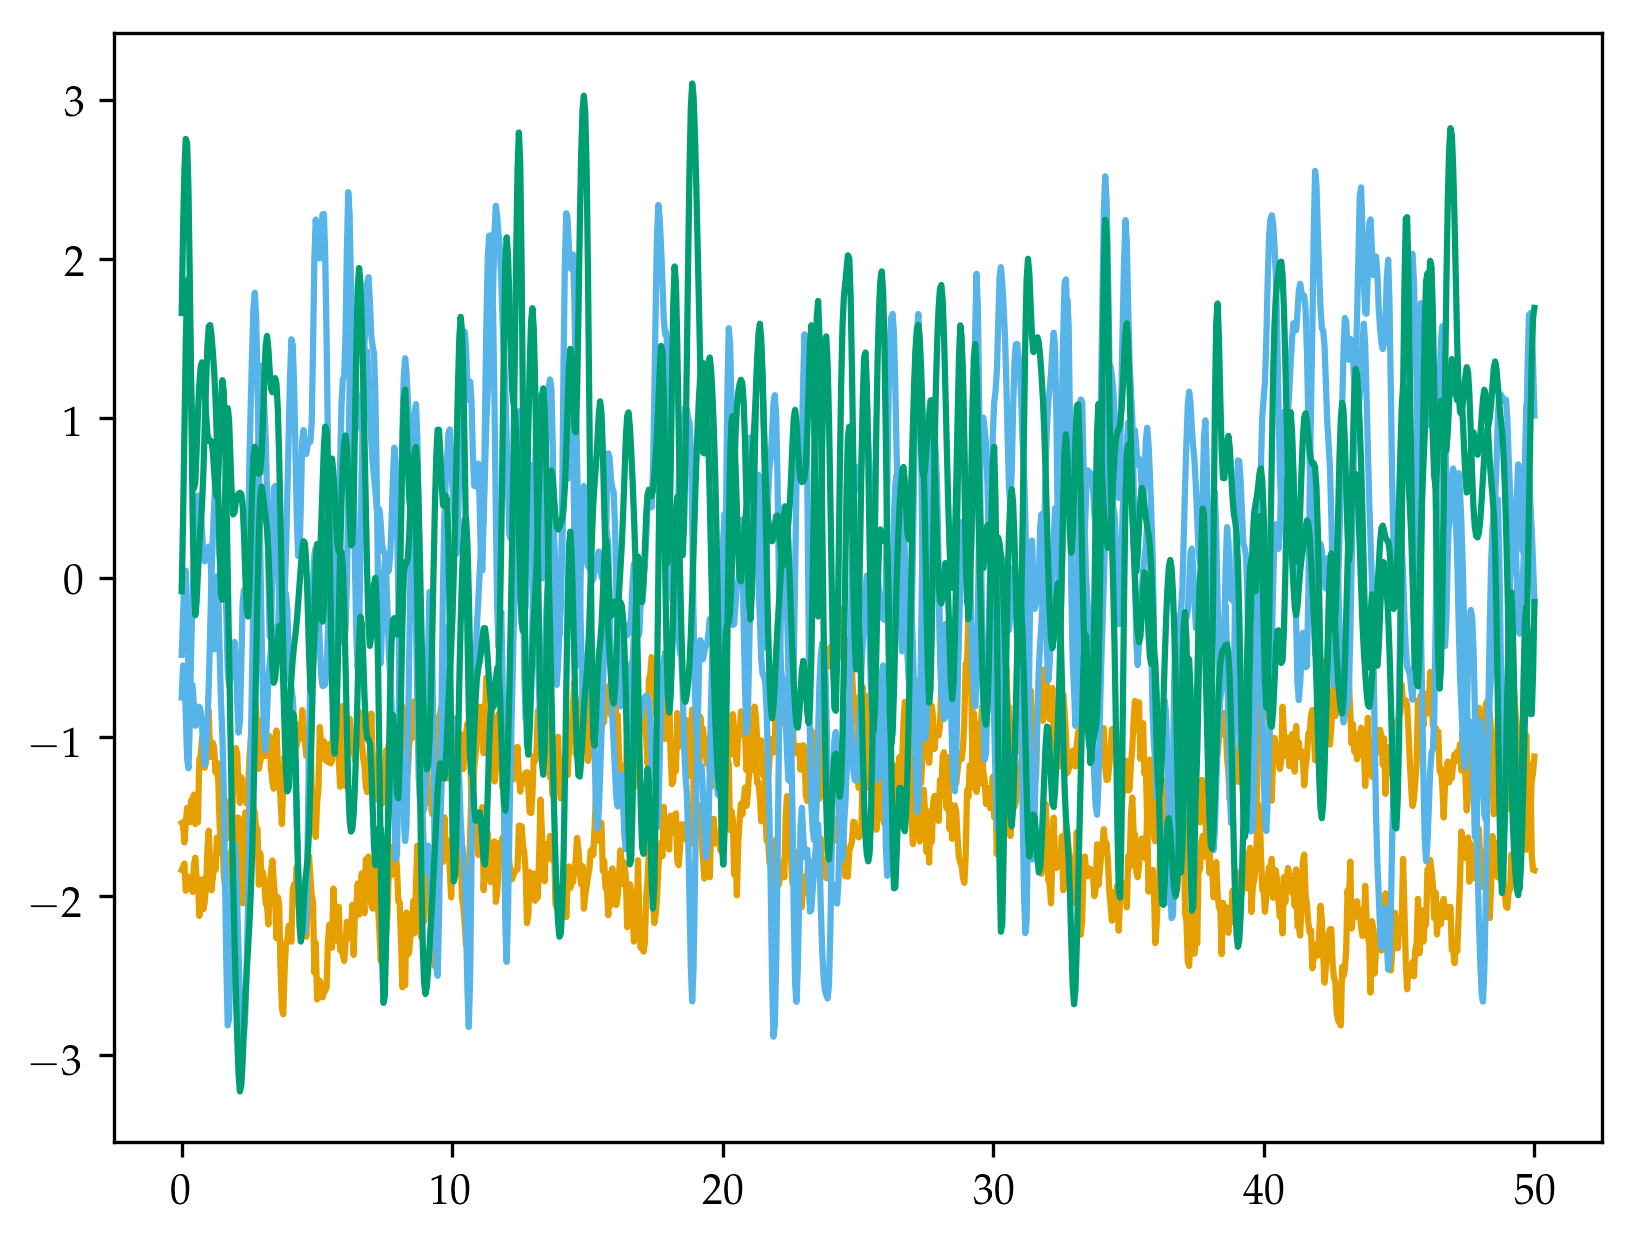

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11af1dd68>

In [11]:
rr = range(0, stop=50.0, length=1000)
X = Matrix(rr')
gp_rq = GPE(; mean=MeanZero(), kernel=rq, logNoise=-20.0)
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
gp_rq1 = GPE(; mean=MeanZero(), kernel=rq1, logNoise=-20.0)
plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])
plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])
gp_se = GPE(; mean=MeanZero(), kernel=se, logNoise=-20.0)
plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])
plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])

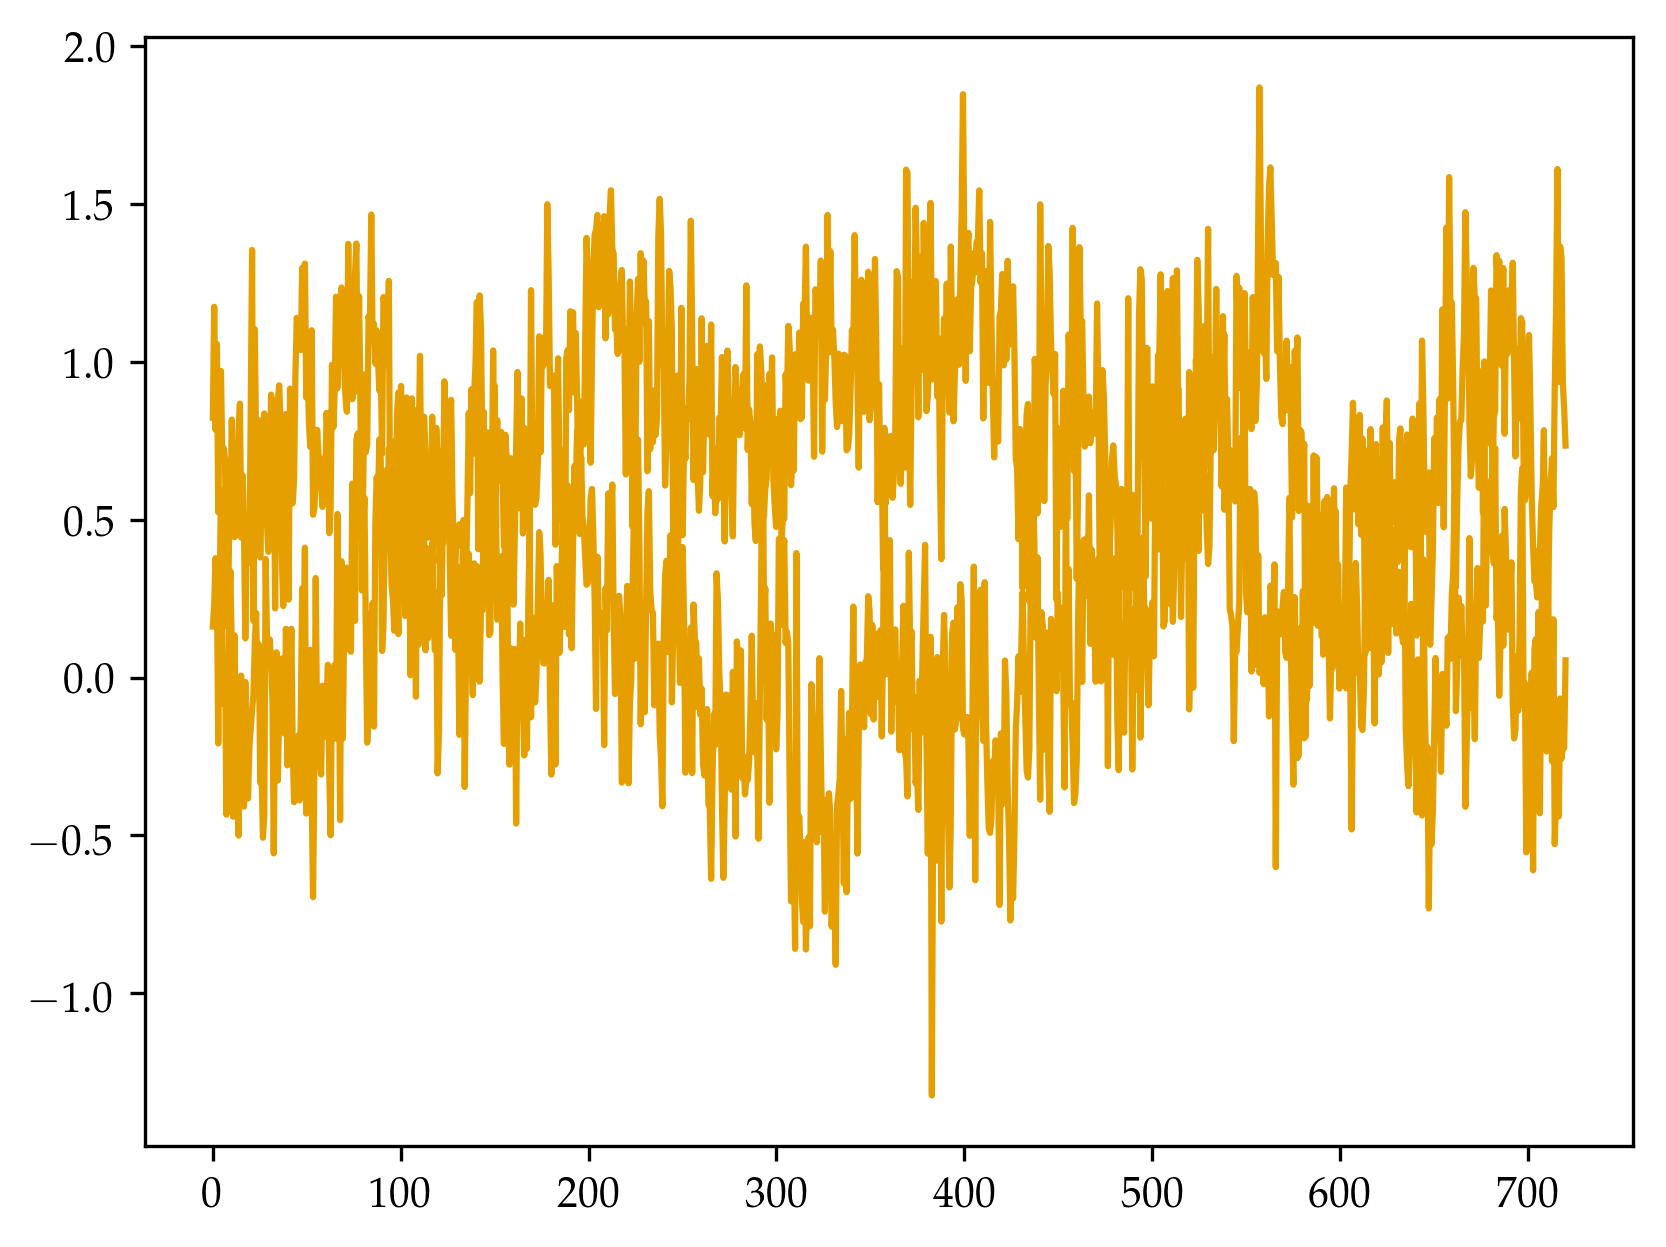

In [15]:
rr = range(0, stop=24*30.0, length=1000)
X = Matrix(rr')
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
;

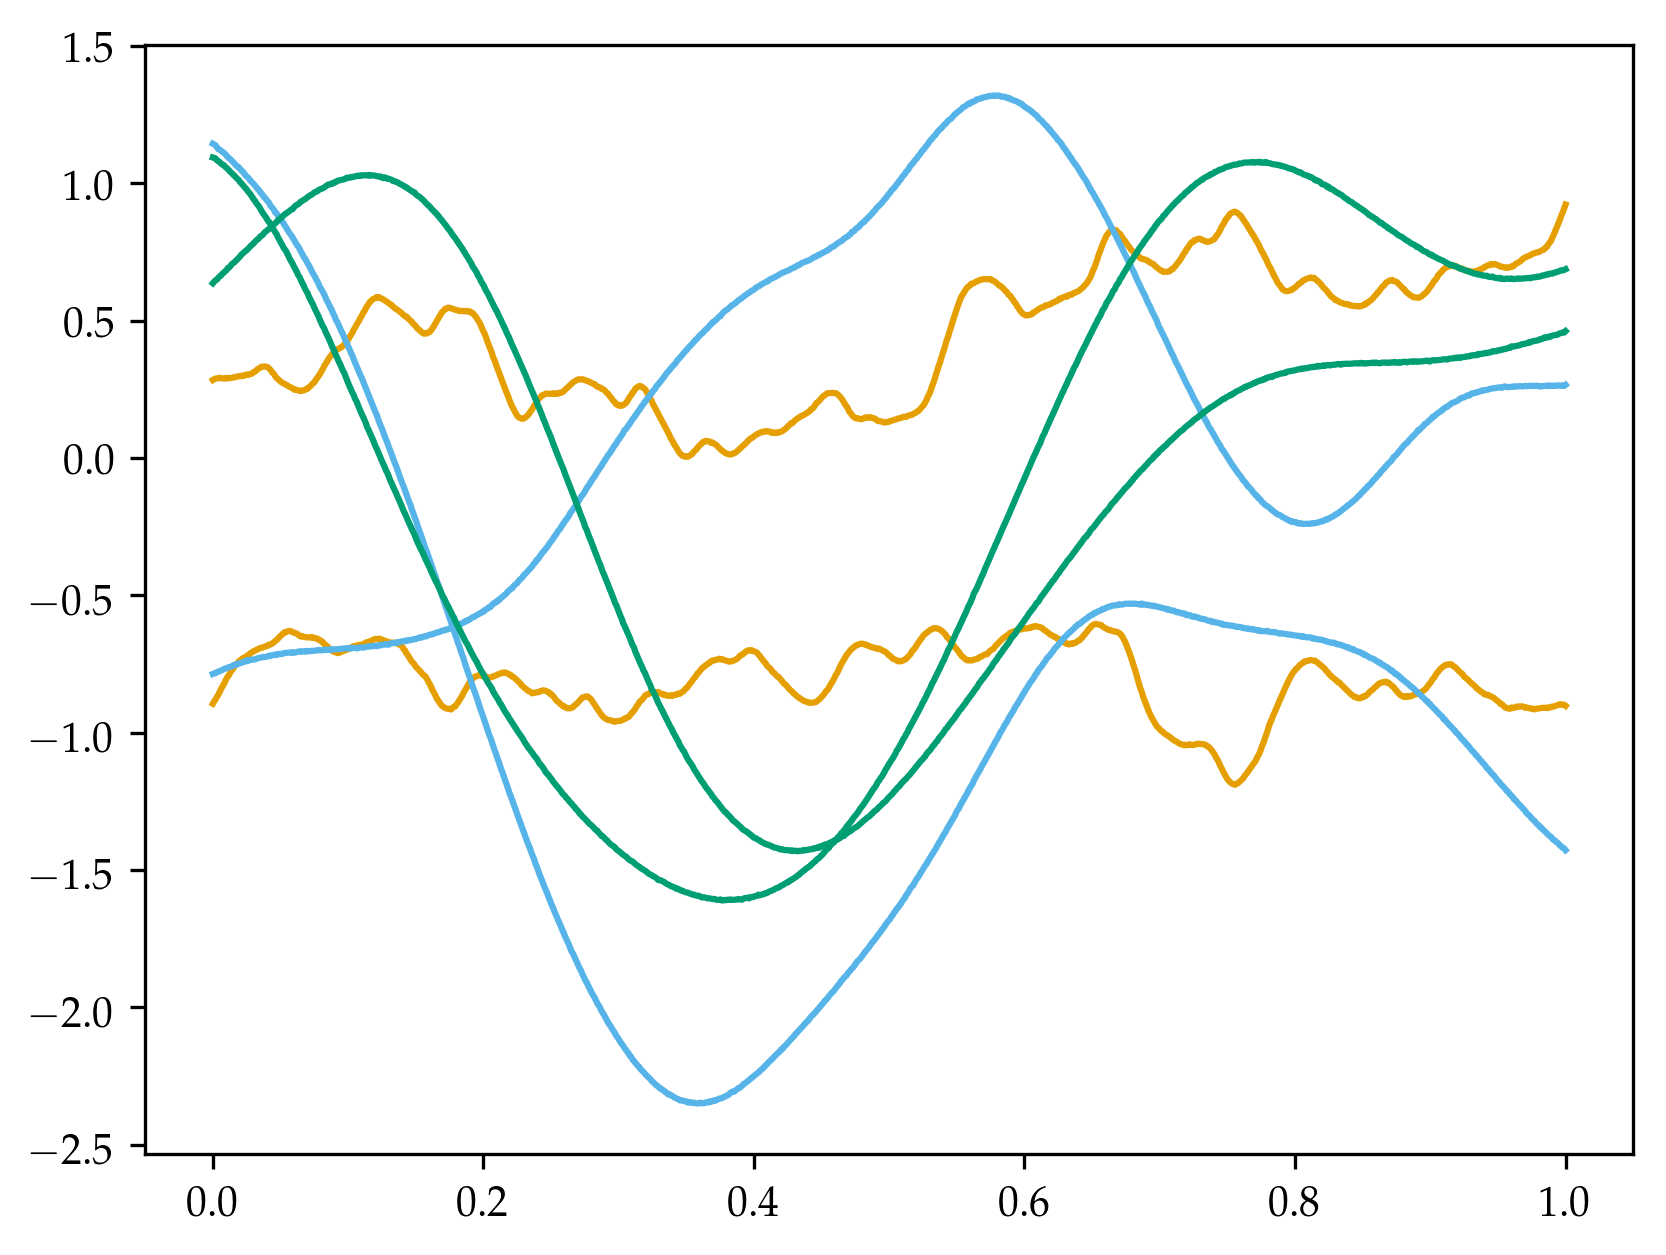

In [13]:
rr = range(0, stop=1.0, length=1000)
X = Matrix(rr')
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])

plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])
plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])

plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])
plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])
;

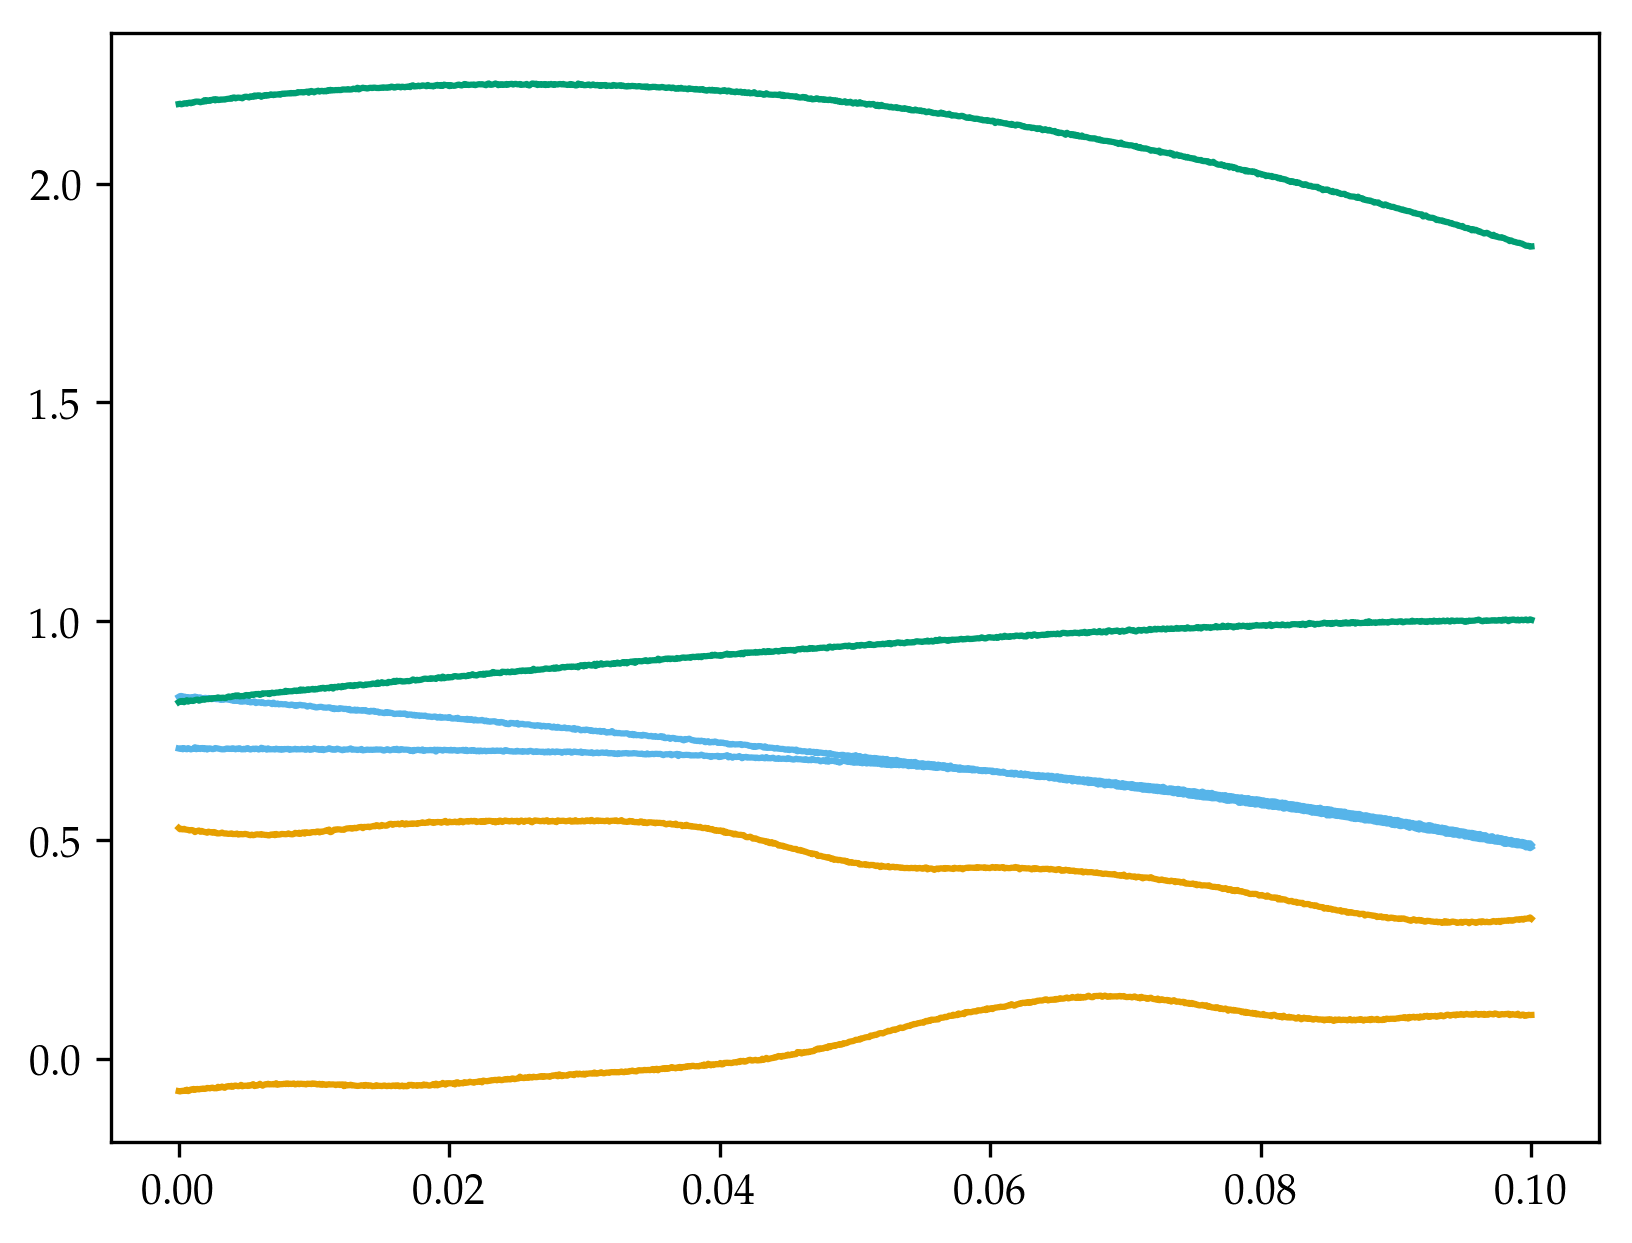

In [14]:
rr = range(0, stop=0.1, length=1000)
X = Matrix(rr')
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])
plt.plot(rr, rand(gp_rq, X), color=cbbPalette[1])

plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])
plt.plot(rr, rand(gp_rq1, X), color=cbbPalette[2])

plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])
plt.plot(rr, rand(gp_se, X), color=cbbPalette[3])
;